# R4 on Salient ImageNet

In [10]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import random
sys.path.append(os.path.abspath('..'))
from models.R4_models import SalientImageNet
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad,
                             accumulate_model_with_certified_input_grad, test_model_accuracy, test_delta_input_robustness,
                             write_results_to_file, uniformize_magnitudes_schedule, train_model_with_smoothed_input_grad)
from datasets import salient_imagenet
from metrics import get_rcs, get_restart_macro_avg_acc_over_labels_with_stddev
from torchvision.models import ResNet18_Weights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the dataloaders 

In [11]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
DELTA_INPUT_ROBUSTNESS_PARAM = 1
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
batch_size = 89
test_batch_size = 250

cuda:1


In [18]:
# DATA_DIR = "/vol/bitbucket/mg2720/imagenet100_data"
# VAL_DIR = "/vol/bitbucket/mg2720/val.X"
# MASKS_DIR = "/vol/bitbucket/mg2720/salient_imagenet_dataset"

concat_imgnet_dset = salient_imagenet.get_simagenet([306, 142, 270, 319, 366, 389])
data_tensors, label_tensors, mask_tensors, groups_tensors = [], [], [], []
for data, label, mask, group in concat_imgnet_dset:
    data_tensors.append(data)
    label_tensors.append(label)
    mask_tensors.append(mask)
    groups_tensors.append(group)

data_tensors = torch.stack(data_tensors)
label_tensors = torch.stack(label_tensors)
mask_tensors = torch.stack(mask_tensors)
groups_tensors = torch.stack(groups_tensors)
dset = torch.utils.data.TensorDataset(data_tensors, label_tensors, mask_tensors, groups_tensors)

print(len(dset))

Read /vol/bitbucket/mg2720/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /vol/bitbucket/mg2720/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389
445


224
torch.Size([224, 224, 3])
tensor(255, dtype=torch.uint8) tensor(5, dtype=torch.uint8)
tensor(5)


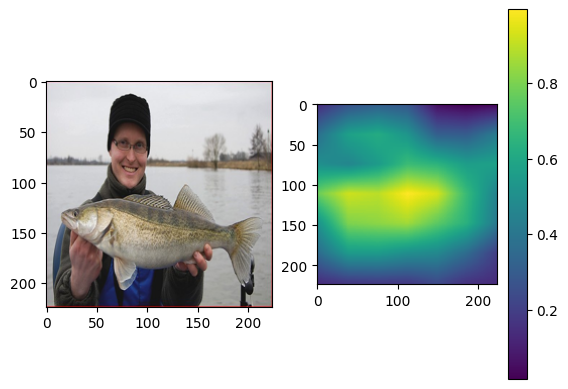

224
torch.Size([224, 224, 3])
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(3)


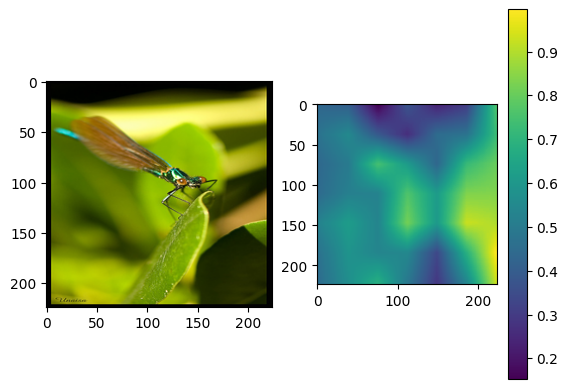

224
torch.Size([224, 224, 3])
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
tensor(1)


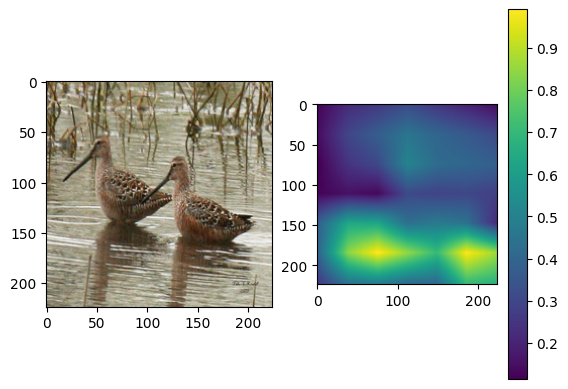

In [ ]:
img, img_label, img_mask = None, None, None
rand_5 = torch.randint(0, len(dset), (3,))
for i in rand_5:
    img, img_label, img_mask, _ = dset[i]
    print(img_mask.shape[0])
    print(img.shape)
    print(torch.max(img), torch.min(img))
    print(img_label)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.numpy())
    im_mask = ax[1].imshow(img_mask[:, :, 0].numpy())
    fig.colorbar(im_mask, ax=ax[1])
    plt.show()

In [28]:
print(len(dset))
dl_train = salient_imagenet.get_dataloader(dset, batch_size, is_train=True)
dl_test = salient_imagenet.get_dataloader(dset, test_batch_size, is_train=False)
print(len(dl_train.dataset), len(dl_test.dataset))
criterion = torch.nn.CrossEntropyLoss()
print(dl_train.dataset[:][1].unique(return_counts=True))
print(dl_test.dataset[:][1].unique(return_counts=True))

445
torch.Size([356, 3, 224, 224]) torch.Size([356]) torch.Size([356, 3, 224, 224])
torch.Size([89, 3, 224, 224]) torch.Size([89]) torch.Size([89, 3, 224, 224])
356 89
(tensor([0, 1, 2, 3, 4, 5]), tensor([55, 89, 55, 51, 53, 53]))
(tensor([0, 1, 2, 3, 4, 5]), tensor([ 9, 25, 14, 13, 12, 16]))


## Experiments 

In [25]:
model_root_save_dir = "saved_experiment_models/performance/imagenet"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["r4", "pgd_r4", "std", "pgd_r4_pmo", "smooth_r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)


In [39]:
std_method = "std"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 4, 5e-4, 4, -1, -1, -1
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc = 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
macro_avg_over_labels, _ = get_restart_macro_avg_acc_over_labels_with_stddev(
    dl_test, save_dir_for_method[std_method], empty_model, device, 6, multi_class=True
)
rcs = get_rcs(dl_test, save_dir_for_method[std_method], device)
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 5),
                       "test_acc": round(test_acc / restarts, 5),
                       "macro_avg_over_labels": round(macro_avg_over_labels, 5),
                       "rcs": round(rcs, 5)}, std_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "test_epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "train_batch_size": dl_train.batch_size,
                         "test_batch_size": dl_train.batch_size,
                         "class_weights": None,
                         "multi_class": True,
                         "has_conv": True,
                         "with_k_schedule": False}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s, loss=1.58, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.7837
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.809
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, loss=1.55, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.9298
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.9326
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, loss=1.58, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.8006
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.8539
========== Training model with method std restart 3 ==========


Epoch: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, loss=1.62, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.6152
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.5955
---- Macro averaged over labels accuracy ----
Macro average and stdev over labels = 0.7596, 0.1461
Core acc = 0.16666666666666666, spur acc = 0.16666666666666666
Rcs = 0.0
Core acc = 0.16666666666666666, spur acc = 0.16666666666666666
Rcs = 0.0
Core acc = 0.16666666666666666, spur acc = 0.16666666666666666
Rcs = 0.0
Core acc = 0.16666666666666666, spur acc = 0.16666666666666666
Rcs = 0.0


# PGD-R4 training

In [41]:
pgd_r4_method = "pgd_r4"
# hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 4, 5e-4, 1, 0.02, 0.1, 1e-4
# Train standard 3 times and test accuracy and delta input robustness for the masked region
train_acc, test_acc = 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet().to(device)

    print(f"========== Training model with method {pgd_r4_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4_method, k, device)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4_method], f"run_{i}.pt"))
empty_model = SalientImageNet().to(device)
macro_avg_over_labels, _ = get_restart_macro_avg_acc_over_labels_with_stddev(
    dl_test, save_dir_for_method[pgd_r4_method], empty_model, device, 6, multi_class=True
)
rcs = get_rcs(dl_test, save_dir_for_method[pgd_r4_method], device)
# write_results_to_file("experiment_results/imagenet.yaml",
#                       {"train_acc": round(train_acc / restarts, 5),
#                        "test_acc": round(test_acc / restarts, 5),
#                        "macro_avg_over_labels": round(macro_avg_over_labels, 5),
#                        "rcs": round(rcs, 5)}, pgd_r4_method)
# write_results_to_file("experiment_results/imagenet_params.yaml",
#                         {"epsilon": epsilon,
#                          "test_epsilon": epsilon,
#                          "k": k,
#                          "weight_coeff": weight_coeff,
#                          "num_epochs": num_epochs,
#                          "lr": lr,
#                          "restarts": restarts,
#                          "train_batch_size": dl_train.batch_size,
#                          "test_batch_size": dl_train.batch_size,
#                          "class_weights": None,
#                          "multi_class": True,
#                          "has_conv": True,
#                          "with_k_schedule": False}, pgd_r4_method)

========== Training model with method pgd_r4 restart 0 ==========


Epoch: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it, loss=1.59, reg=tensor(0.0080, device='cuda:1', grad_fn=<MulBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.7556
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.7753
---- Macro averaged over labels accuracy ----
Macro average and stdev over labels = 0.7162, nan
Core acc = 0.16666666666666666, spur acc = 0.16666666666666666
Rcs = 0.0


In [ ]:
pgd_r4_pmo = "pgd_r4_pmo" # Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 8, 1e-4, 3, 0.03, 1e-5, 1
train_acc, test_acc = 0, 0
new_batch_size = 262
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size, drop_last=True)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {pgd_r4_pmo} small restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4_pmo,
        k, device, weight_reg_coeff=weight_coeff, num_iterations=10)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4_pmo + "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(curr_model, dl_test, device, 6, save_dir_for_method[pgd_r4_pmo + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg,}, pgd_r4_pmo)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, pgd_r4_pmo)

In [ ]:
smooth_r3 = "smooth_r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 8e-5, 3, 0.01, 1e-6, 400
train_acc, test_acc = 0, 0
new_batch_size = 150
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {smooth_r3} restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3, k,
        device, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3 + "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[smooth_r3 + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "worst_group_acc": round(wg_acc, 3),
                       "worst_group": wg}, smooth_r3)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts}, smooth_r3)

In [ ]:
rand_r4_pmo = "rand_r4_pmo"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 7, 8e-5, 3, 0.03, 0, 2e+5
train_acc, test_acc = 0, 0
new_batch_size = 150
dl_train = salient_imagenet.get_dataloader(train_imgnet, new_batch_size)
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet()

    print(f"========== Training model with method {rand_r4_pmo} small restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rand_r4_pmo, k,
        device, weight_reg_coeff=weight_coeff, perturb_mask_only=True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    worst_group_acc_no_load(curr_model, dl_test, device, 6)
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rand_r4_pmo + "_small"], f"run_{i}.pt"))
empty_model = SalientImageNet()
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[rand_r4_pmo + "_small"])
write_results_to_file("experiment_results/imagenet_small.yaml",
                      {"train_acc": round(train_acc / restarts, 4),
                       "test_acc": round(test_acc / restarts, 4),
                       "worst_group_acc": round(wg_acc, 4),
                       "worst_group": wg}, rand_r4_pmo)
write_results_to_file("experiment_results/imagenet_small_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rand_r4_pmo)